In [19]:
%load_ext autoreload

%autoreload 2

import tools as t
import readdata as rm
import predictive_model as m
import evaluate as e

from lentil import models
from lentil import evaluate
from lentil import datatools

import pandas as pd
import numpy as np
import pickle
import math

import plotly
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read Raw Data and Generate Features into 'processed_data.txt'

In [ ]:
rm.getTrainingInstances('raw_data/spanish_data.csv','spanish_processed.txt', 0, 2, 1, 3)

In [ ]:
rm.getTrainingInstances('raw_data/radical_transfer_2007.csv','radical_processed.txt', 0, 3, 2, 4)

In [ ]:
rm.getTrainingInstances('raw_data/chinese-hundredthousand.csv','chinese_processed.txt', 0, 3, 2, 4, 'pickles/history.pkl')

Convert processed data into Interaction History object

In [ ]:
spanish_history = t.textToInteractionHistory('spanish_processed.txt', 'timestamp', 'student_id','module_id','outcome', 'True')

t.savePickle(spanish_history, 'datasets/spanish.pkl')

In [ ]:
radical_history = t.textToInteractionHistory('radical_processed.txt', 'timestamp', 'student_id','module_id','outcome', 'True')

filtered_radical = t.filterHistory(radical_history.data)
t.savePickle(filtered_radical, 'datasets/radical.pkl')

In [ ]:
chinese_history = t.textToInteractionHistory('chinese_processed.txt', 'timestamp', 'student_id','module_id','outcome', 'True')

t.savePickle(chinese_history, 'datasets/chinese.pkl')

Load ready-to-go datasets from pickles

In [164]:
spanish_history = t.loadPickle('datasets/spanish.pkl')

In [165]:
radical_history = t.loadPickle('datasets/radical.pkl')

In [166]:
chinese_history = t.loadPickle('datasets/chinese.pkl')

In [167]:
chinese_2007_history = t.loadPickle('datasets/chinese_2007.pkl')

In [ ]:
mnemosyne_history = t.loadPickle('datasets/mnemosyne.pkl')

In [128]:
chinese_spring = t.loadPickle('datasets/chinese_spring.pkl')

Check properties of data

In [169]:
print 'SPANISH'
print str(spanish_history.num_students()) + ' students'
print str(spanish_history.num_assessments()) + ' assessments'
print str(len(spanish_history.data)) + ' interactions'
print t.getTrueFalseDistribution(spanish_history.data) + '\n'

print 'RADICAL'
print str(radical_history.num_students()) + ' students'
print str(radical_history.num_assessments()) + ' assessments'
print str(len(radical_history.data)) + ' interactions'
print t.getTrueFalseDistribution(radical_history.data) + '\n'

print 'CHINESE'
print str(chinese_history.num_students()) + ' students'
print str(chinese_history.num_assessments()) + ' assessments'
print str(len(chinese_history.data)) + ' interactions'
print t.getTrueFalseDistribution(chinese_history.data) + '\n'

print 'CHINESE 2007'
print str(chinese_2007_history.num_students()) + ' students'
print str(chinese_2007_history.num_assessments()) + ' assessments'
print str(len(chinese_2007_history.data)) + ' interactions'
print t.getTrueFalseDistribution(chinese_2007_history.data) + '\n'

SPANISH
21 students
668 assessments
9719 interactions
True/Total: 0.787735363721

RADICAL
90 students
466 assessments
43799 interactions
True/Total: 0.831685654924

CHINESE
101 students
919 assessments
79119 interactions
True/Total: 0.865000821547

CHINESE 2007
87 students
1091 assessments
81199 interactions
True/Total: 0.797780760847



In [ ]:
print 'MNEMOSYNE'
print str(mnemosyne_history.num_students()) + ' students'
print str(mnemosyne_history.num_assessments()) + ' assessments'
print t.getTrueFalseDistribution(mnemosyne_history.data) + '\n'

Online Prediction Accuracy: Spanish, Radical and Chinese Datasets

Training population: 20%; Testing population: 80%

In [ ]:
#split history
train_chinese, test_chinese = t.splitHistory(chinese_history, 70)

In [159]:
train_spanish, test_spanish = t.splitHistory(spanish_history, 70)

In [83]:
train_radical, test_radical = t.splitHistory(radical_history, 70)

In [55]:
train_chinese_2007, test_chinese_2007 = t.splitHistory(chinese_2007_history, 70)

In [102]:
train_mnemosyne, test_mnemosyne = t.splitHistory(mnemosyne_history, 70)

Set train and test datasets

In [103]:
total, train, test = mnemosyne_history, train_mnemosyne, test_mnemosyne

Train models

In [108]:
efc_model = e.train_efc(train.data, train.data)

In [155]:
onepl_model = e.train_onepl(train.data, train.data)

In [141]:
random_model = e.train_random(train.data, train.data)

In [142]:
percentage_model = e.train_percentage(train.data, train.data)

In [151]:
logistic_model = e.train_logistic(train.data, train.data)

Evaluate

In [ ]:
evaluate.training_auc(efc_model, test, True)

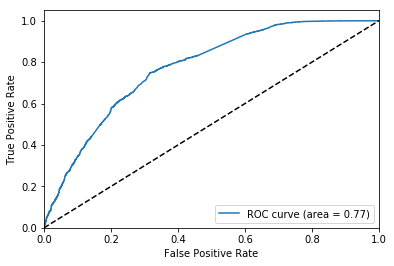

0.77308320356286542

In [152]:
evaluate.training_auc(logistic_model, test)

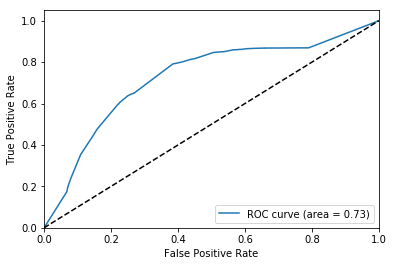

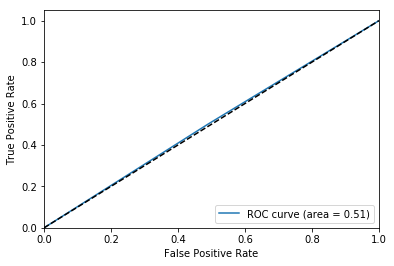

In [146]:
perc_auc = evaluate.training_auc(percentage_model, test, True)
random_auc = evaluate.training_auc(random_model, test, True)

Generate Results

In [ ]:
results = e.getResults(total, 4, True)

Read Results

In [160]:
results = t.loadPickle('results/chinese_2006.pkl')

In [161]:
e.overallAccuracy(['EFC','LR','PERC','IRT'], results, 'AUC', 'Chinese 2006')